# Multitemporal Urban Change Detection in New Delhi using Sentinel-1 SAR Data

This notebook demonstrates multitemporal change detection in New Delhi using Sentinel-1 SAR data accessed through the openEO API. Unlike bi-temporal analysis, this approach analyzes multiple time periods to create:

1. **Change Frequency Map**: Shows how often changes occur at each pixel location
2. **Time-series Analysis**: Displays backscatter evolution for specific pixels over time

## Requirements
- SAR4CET toolkit (will be installed below)
- openEO Python client
- Copernicus Dataspace account for authentication
- xarray, matplotlib, numpy for data processing and visualization

## 0. Setup and Installation

First, let's clone the SAR4CET repository and install all required dependencies.

In [1]:
# Clone the SAR4CET repository
import os
import subprocess
import sys

# Check if SAR4CET directory already exists
if not os.path.exists('SAR4CET'):
    print('Cloning SAR4CET repository...')
    result = subprocess.run(['git', 'clone', 'https://github.com/naikp13/SAR4CET.git'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        print('Repository cloned successfully!')
    else:
        print(f'Error cloning repository: {result.stderr}')
else:
    print('SAR4CET directory already exists.')

Cloning SAR4CET repository...
Repository cloned successfully!


In [2]:
# Install requirements from requirements.txt
print('Installing SAR4CET requirements...')

# Change to SAR4CET directory and install requirements
if os.path.exists('SAR4CET/requirements.txt'):
    result = subprocess.run([sys.executable, '-m', 'pip', 'install', '-r', 'SAR4CET/requirements.txt'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        print('Requirements installed successfully!')
        print('Installed packages from requirements.txt')
    else:
        print(f'Error installing requirements: {result.stderr}')
        print('Trying to install individual packages...')
        # Try installing key packages individually
        key_packages = ['openeo>=0.22.0', 'xarray>=0.19.0', 'numpy>=1.20.0',
                       'matplotlib>=3.4.0', 'rasterio>=1.2.0', 'scipy>=1.7.0']
        for package in key_packages:
            subprocess.run([sys.executable, '-m', 'pip', 'install', package])
else:
    print('requirements.txt not found, installing key packages manually...')
    key_packages = ['openeo>=0.22.0', 'xarray>=0.19.0', 'numpy>=1.20.0',
                   'matplotlib>=3.4.0', 'rasterio>=1.2.0', 'scipy>=1.7.0']
    for package in key_packages:
        subprocess.run([sys.executable, '-m', 'pip', 'install', package])

Installing SAR4CET requirements...
Requirements installed successfully!
Installed packages from requirements.txt


In [3]:
# Add SAR4CET to Python path for imports
import sys
import os

# Add SAR4CET directory to Python path
sar4cet_path = os.path.abspath('SAR4CET')
if sar4cet_path not in sys.path:
    sys.path.insert(0, sar4cet_path)
    print(f'Added {sar4cet_path} to Python path')

# Verify installation by importing key modules
try:
    import openeo
    import xarray as xr
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import ndimage
    print('All required packages imported successfully!')
    print(f'openEO version: {openeo.__version__}')
    print(f'xarray version: {xr.__version__}')
except ImportError as e:
    print(f'Import error: {e}')
    print('Please install missing packages manually.')

Added /content/SAR4CET to Python path
All required packages imported successfully!
openEO version: 0.43.0
xarray version: 2025.1.1


## Import Required Libraries

Now let's import all the libraries we'll need for the multitemporal analysis.

In [4]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from scipy import ndimage
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Optional: Import SAR4CET modules if available
try:
    from sar4cet import preprocessing, visualization
    print('SAR4CET modules imported successfully!')
except ImportError:
    print('SAR4CET modules not available, using standalone approach.')

SAR4CET modules imported successfully!


## 1. Connect to openEO Backend

Connect to the Copernicus Dataspace openEO backend and authenticate.

In [5]:
# Connect to Copernicus Dataspace openEO backend
backend = 'openeo.dataspace.copernicus.eu'
conn = openeo.connect(backend).authenticate_oidc()
print(f'Connected to {backend}')

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=MZYJ-GRIQ 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
Connected to openeo.dataspace.copernicus.eu


## 2. Define Area of Interest and Time Periods

We'll focus on the same developing area in South Delhi but analyze multiple time periods over several years.

In [6]:
# Area of Interest: Developing area in South Delhi (Gurgaon-Delhi border)
spatial_extent = {
    'west': 77.0500,
    'east': 77.1200,
    'south': 28.4200,
    'north': 28.4800,
    'crs': 'EPSG:4326',
}

# Define multiple time periods for multitemporal analysis
# We'll analyze quarterly periods over 3 years (2021-2023)
time_periods = [
    ['2021-01-01', '2021-03-31'],  # Q1 2021
    ['2021-04-01', '2021-06-30'],  # Q2 2021
    ['2021-07-01', '2021-09-30'],  # Q3 2021
    ['2021-10-01', '2021-12-31'], # Q4 2021
    ['2022-01-01', '2022-03-31'],  # Q1 2022
    ['2022-04-01', '2022-06-30'],  # Q2 2022
    ['2022-07-01', '2022-09-30'],  # Q3 2022
    ['2022-10-01', '2022-12-31'], # Q4 2022
    ['2023-01-01', '2023-03-31'],  # Q1 2023
    ['2023-04-01', '2023-06-30'],  # Q2 2023
    ['2023-07-01', '2023-09-30'],  # Q3 2023
    ['2023-10-01', '2023-12-31'], # Q4 2023
]

print(f'Area of Interest: {spatial_extent}')
print(f'Number of time periods: {len(time_periods)}')
print(f'Time range: {time_periods[0][0]} to {time_periods[-1][1]}')

Area of Interest: {'west': 77.05, 'east': 77.12, 'south': 28.42, 'north': 28.48, 'crs': 'EPSG:4326'}
Number of time periods: 12
Time range: 2021-01-01 to 2023-12-31


## 3. Load and Process Multitemporal Sentinel-1 Data

Load Sentinel-1 data for all time periods and apply SAR backscatter processing.

In [13]:
# Function to load and process SAR data for a given time period
def load_and_process_sar(conn, spatial_extent, temporal_extent, period_name):
    '''Load and process SAR data for a specific time period'''
    print(f'Processing {period_name}: {temporal_extent[0]} to {temporal_extent[1]}')

    # Load Sentinel-1 data
    s1 = conn.load_collection(
        'SENTINEL1_GRD',
        spatial_extent=spatial_extent,
        bands=['VV', 'VH'],
        temporal_extent=temporal_extent,
        properties={'sat:orbit_state': lambda od: od == 'ASCENDING'},
    )

    # Apply SAR backscatter processing
    s1_scatter = s1.sar_backscatter(
        coefficient='sigma0-ellipsoid',
        elevation_model='COPERNICUS_30'
    )

    # Convert to dB scale
    s1bs = s1_scatter.apply(lambda x: 10 * x.log(base=10))

    # Create median composite
    s1_median = s1bs.median_time()

    return s1_median

print('Function defined for SAR data processing')

Function defined for SAR data processing


In [14]:
# Process all time periods (this may take some time)
print('Starting multitemporal data processing...')
print('Note: This process may take 10-15 minutes depending on data availability')

processed_periods = []
period_names = []

for i, period in enumerate(time_periods):
    period_name = f'Period_{i+1:02d}_{period[0][:7]}'  # e.g., Period_01_2021-01
    period_names.append(period_name)

    try:
        processed_data = load_and_process_sar(conn, spatial_extent, period, period_name)
        processed_periods.append(processed_data)
        print(f'✓ Successfully processed {period_name}')
    except Exception as e:
        print(f'✗ Error processing {period_name}: {str(e)}')
        processed_periods.append(None)

# Filter out None values
valid_periods = [(name, data) for name, data in zip(period_names, processed_periods) if data is not None]
print(f'\nSuccessfully processed {len(valid_periods)} out of {len(time_periods)} periods')

Starting multitemporal data processing...
Note: This process may take 10-15 minutes depending on data availability
Processing Period_01_2021-01: 2021-01-01 to 2021-03-31
✓ Successfully processed Period_01_2021-01
Processing Period_02_2021-04: 2021-04-01 to 2021-06-30
✓ Successfully processed Period_02_2021-04
Processing Period_03_2021-07: 2021-07-01 to 2021-09-30
✓ Successfully processed Period_03_2021-07
Processing Period_04_2021-10: 2021-10-01 to 2021-12-31
✓ Successfully processed Period_04_2021-10
Processing Period_05_2022-01: 2022-01-01 to 2022-03-31
✓ Successfully processed Period_05_2022-01
Processing Period_06_2022-04: 2022-04-01 to 2022-06-30
✓ Successfully processed Period_06_2022-04
Processing Period_07_2022-07: 2022-07-01 to 2022-09-30
✓ Successfully processed Period_07_2022-07
Processing Period_08_2022-10: 2022-10-01 to 2022-12-31
✓ Successfully processed Period_08_2022-10
Processing Period_09_2023-01: 2023-01-01 to 2023-03-31
✓ Successfully processed Period_09_2023-01
Pro

## 4. Download Processed Data

Download the processed SAR data for all valid time periods.

In [15]:
# Download all processed periods
downloaded_files = []

print('Downloading processed data...')
for period_name, processed_data in valid_periods:
    filename = f'new_delhi_{period_name.lower()}.nc'
    try:
        print(f'Downloading {filename}...')
        processed_data.download(filename)
        downloaded_files.append((period_name, filename))
        print(f'✓ Downloaded {filename}')
    except Exception as e:
        print(f'✗ Error downloading {filename}: {str(e)}')

print(f'\nDownloaded {len(downloaded_files)} files successfully')

✓ Downloaded new_delhi_period_01_2021-01.nc
✓ Downloaded new_delhi_period_02_2021-04.nc
✓ Downloaded new_delhi_period_03_2021-07.nc
✓ Downloaded new_delhi_period_04_2021-10.nc
✓ Downloaded new_delhi_period_05_2022-01.nc
✓ Downloaded new_delhi_period_06_2022-04.nc
✓ Downloaded new_delhi_period_07_2022-07.nc
✓ Downloaded new_delhi_period_08_2022-10.nc
✓ Downloaded new_delhi_period_09_2023-01.nc
✓ Downloaded new_delhi_period_10_2023-04.nc
✓ Downloaded new_delhi_period_11_2023-07.nc
✓ Downloaded new_delhi_period_12_2023-10.nc

Downloaded 12 files successfully


## 5. Load Downloaded Data and Create Time Series

Load all downloaded NetCDF files and organize them into a time series dataset.

In [16]:
# Load all downloaded files into a list
datasets = []
time_labels = []

for period_name, filename in downloaded_files:
    try:
        ds = xr.open_dataset(filename)
        datasets.append(ds)
        time_labels.append(period_name)
        print(f'Loaded {filename} - Shape: {ds.dims}')
    except Exception as e:
        print(f'Error loading {filename}: {str(e)}')

print(f'\nLoaded {len(datasets)} datasets for analysis')

if len(datasets) > 0:
    print(f'Dataset dimensions: {datasets[0].dims}')
    print(f'Available bands: {list(datasets[0].data_vars)}')
else:
    print('No datasets available for analysis')

Loaded new_delhi_period_01_2021-01.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_02_2021-04.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_03_2021-07.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_04_2021-10.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_05_2022-01.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_06_2022-04.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_07_2022-07.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_08_2022-10.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_09_2023-01.nc - Shape: FrozenMappingWarningOnValuesAccess({'x': 698, 'y': 678})
Loaded new_delhi_period_10_2023-04.nc - Shape: FrozenMappingWarn

In [17]:
# Create multitemporal arrays for VV and VH
if len(datasets) > 0:
    # Extract VV and VH data from all time periods
    vv_timeseries = np.stack([ds.VV.values for ds in datasets], axis=0)
    vh_timeseries = np.stack([ds.VH.values for ds in datasets], axis=0)

    print(f'VV time series shape: {vv_timeseries.shape}')
    print(f'VH time series shape: {vh_timeseries.shape}')
    print(f'Time dimension: {len(time_labels)} periods')

    # Get spatial coordinates
    x_coords = datasets[0].x.values
    y_coords = datasets[0].y.values

    print(f'Spatial extent - X: {x_coords.min():.4f} to {x_coords.max():.4f}')
    print(f'Spatial extent - Y: {y_coords.min():.4f} to {y_coords.max():.4f}')
else:
    print('Cannot create time series - no valid datasets')

VV time series shape: (12, 678, 698)
VH time series shape: (12, 678, 698)
Time dimension: 12 periods
Spatial extent - X: 700685.0000 to 707655.0000
Spatial extent - Y: 3145435.0000 to 3152205.0000


## 6. Change Detection Analysis

Perform multitemporal change detection to identify when and how often changes occur.

In [18]:
# Function to detect changes between consecutive time periods
def detect_temporal_changes(timeseries, threshold=2.0):
    '''
    Detect changes between consecutive time periods

    Parameters:
    - timeseries: 3D array (time, y, x)
    - threshold: Change threshold in dB

    Returns:
    - change_mask: 3D boolean array indicating changes
    - change_magnitude: 3D array with change magnitudes
    '''
    n_times, height, width = timeseries.shape
    change_mask = np.zeros((n_times-1, height, width), dtype=bool)
    change_magnitude = np.zeros((n_times-1, height, width))

    for t in range(n_times-1):
        # Calculate difference between consecutive periods
        diff = timeseries[t+1] - timeseries[t]

        # Apply threshold to detect significant changes
        change_mask[t] = np.abs(diff) > threshold
        change_magnitude[t] = diff

    return change_mask, change_magnitude

if len(datasets) > 1:
    # Detect changes for VV polarization
    vv_change_mask, vv_change_magnitude = detect_temporal_changes(vv_timeseries, threshold=2.0)

    # Detect changes for VH polarization
    vh_change_mask, vh_change_magnitude = detect_temporal_changes(vh_timeseries, threshold=1.5)

    print(f'VV change detection completed - Shape: {vv_change_mask.shape}')
    print(f'VH change detection completed - Shape: {vh_change_mask.shape}')
else:
    print('Need at least 2 time periods for change detection')

VV change detection completed - Shape: (11, 678, 698)
VH change detection completed - Shape: (11, 678, 698)


## 7. Create Change Frequency Map

Generate a map showing how frequently changes occur at each pixel location.

In [19]:
if len(datasets) > 1:
    # Calculate change frequency (number of times each pixel changed)
    vv_change_frequency = np.sum(vv_change_mask, axis=0)
    vh_change_frequency = np.sum(vh_change_mask, axis=0)

    # Combined change frequency (either VV or VH changed)
    combined_change_mask = vv_change_mask | vh_change_mask
    combined_change_frequency = np.sum(combined_change_mask, axis=0)

    # Calculate change frequency as percentage
    max_possible_changes = len(datasets) - 1
    vv_change_frequency_pct = (vv_change_frequency / max_possible_changes) * 100
    vh_change_frequency_pct = (vh_change_frequency / max_possible_changes) * 100
    combined_change_frequency_pct = (combined_change_frequency / max_possible_changes) * 100

    print(f'Maximum possible changes per pixel: {max_possible_changes}')
    print(f'VV - Max changes observed: {vv_change_frequency.max()}')
    print(f'VH - Max changes observed: {vh_change_frequency.max()}')
    print(f'Combined - Max changes observed: {combined_change_frequency.max()}')

    # Statistics
    total_pixels = vv_change_frequency.size
    changed_pixels = np.sum(combined_change_frequency > 0)
    print(f'\nPixels that changed at least once: {changed_pixels} ({changed_pixels/total_pixels*100:.2f}%)')
else:
    print('Cannot create change frequency map - insufficient data')

Maximum possible changes per pixel: 11
VV - Max changes observed: 11
VH - Max changes observed: 11
Combined - Max changes observed: 11

Pixels that changed at least once: 463714 (97.99%)


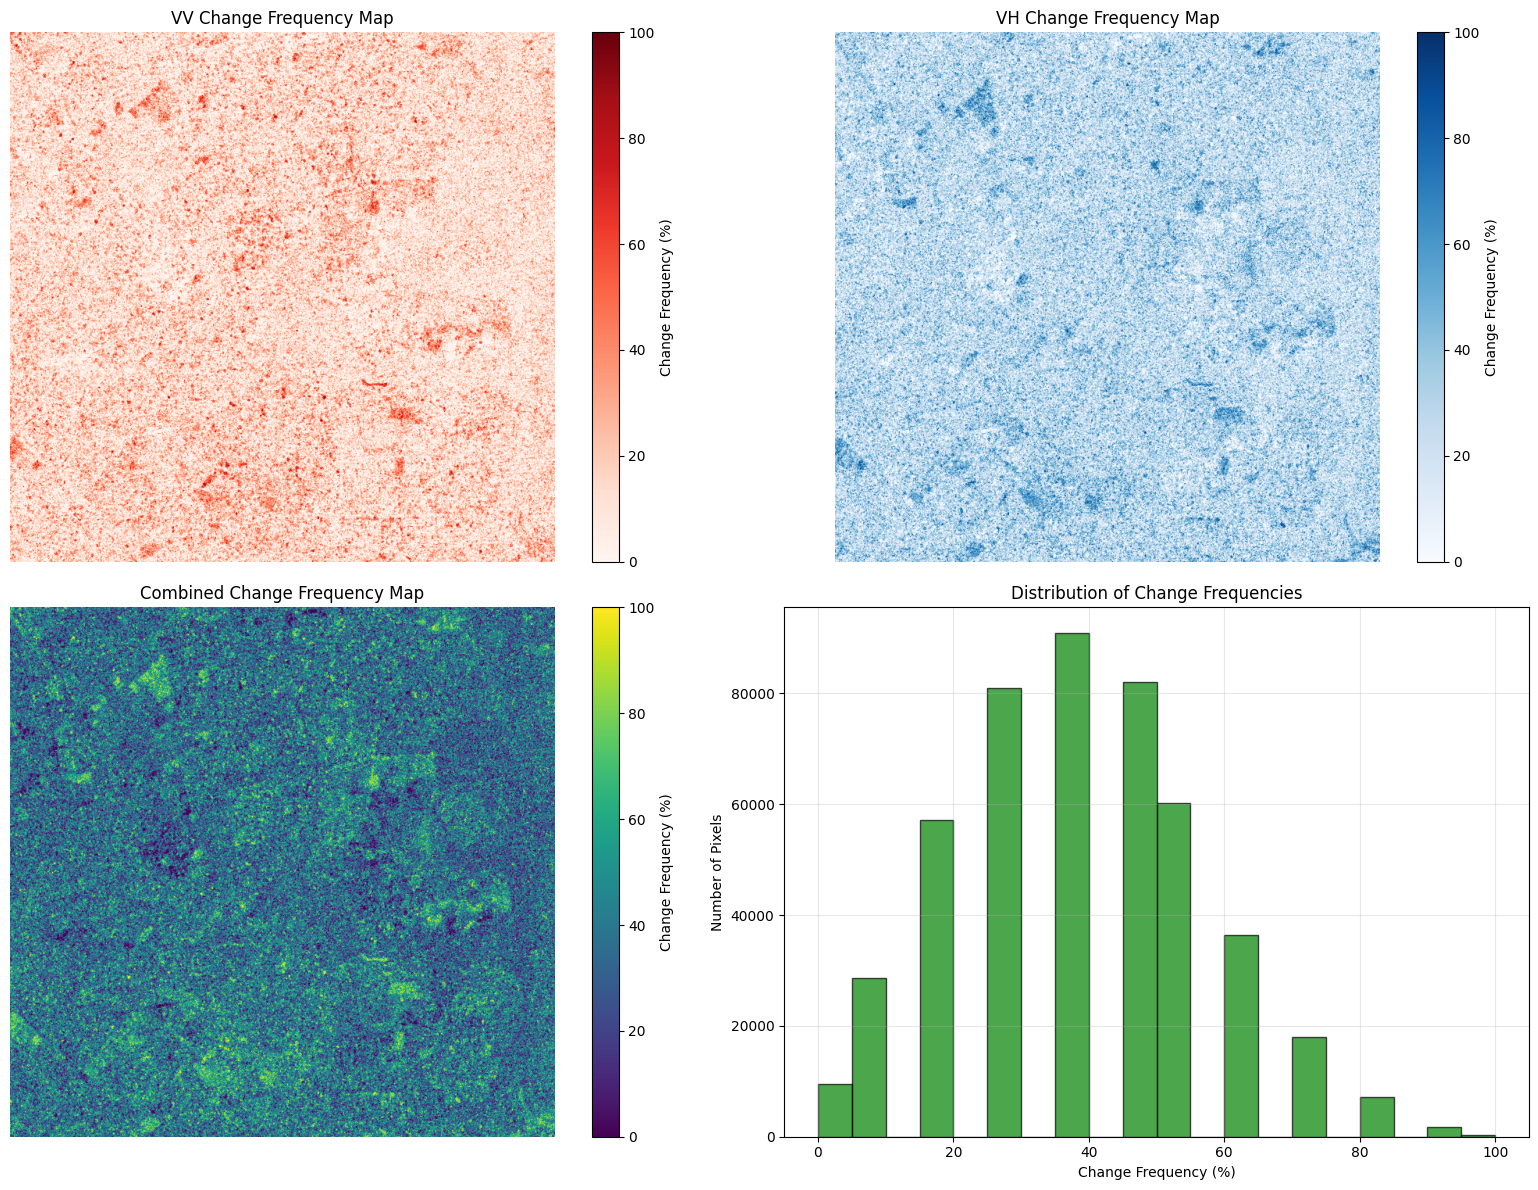


Interpretation:
- Red/Blue areas: High change frequency (frequent urban development)
- Dark areas: Low/no change frequency (stable areas)
- Combined map shows overall change activity


In [20]:
# Visualize change frequency maps
if len(datasets) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # VV change frequency
    im1 = axes[0, 0].imshow(vv_change_frequency_pct, cmap='Reds', vmin=0, vmax=100)
    axes[0, 0].set_title('VV Change Frequency Map')
    axes[0, 0].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[0, 0], label='Change Frequency (%)')

    # VH change frequency
    im2 = axes[0, 1].imshow(vh_change_frequency_pct, cmap='Blues', vmin=0, vmax=100)
    axes[0, 1].set_title('VH Change Frequency Map')
    axes[0, 1].axis('off')
    cbar2 = plt.colorbar(im2, ax=axes[0, 1], label='Change Frequency (%)')

    # Combined change frequency
    im3 = axes[1, 0].imshow(combined_change_frequency_pct, cmap='viridis', vmin=0, vmax=100)
    axes[1, 0].set_title('Combined Change Frequency Map')
    axes[1, 0].axis('off')
    cbar3 = plt.colorbar(im3, ax=axes[1, 0], label='Change Frequency (%)')

    # Change frequency histogram
    axes[1, 1].hist(combined_change_frequency_pct.flatten(), bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[1, 1].set_xlabel('Change Frequency (%)')
    axes[1, 1].set_ylabel('Number of Pixels')
    axes[1, 1].set_title('Distribution of Change Frequencies')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print('\nInterpretation:')
    print('- Red/Blue areas: High change frequency (frequent urban development)')
    print('- Dark areas: Low/no change frequency (stable areas)')
    print('- Combined map shows overall change activity')
else:
    print('Cannot visualize change frequency maps - insufficient data')

## 8. Time-Series Analysis for Specific Pixels

Select specific pixels and analyze their backscatter evolution over time.

In [21]:
# Function to select interesting pixels for time-series analysis
def select_analysis_pixels(change_frequency_map, n_pixels=5):
    '''
    Select pixels with different change characteristics for analysis

    Returns:
    - List of (row, col, description) tuples
    '''
    height, width = change_frequency_map.shape
    pixels = []

    # 1. Pixel with highest change frequency
    max_change_idx = np.unravel_index(np.argmax(change_frequency_map), change_frequency_map.shape)
    pixels.append((max_change_idx[0], max_change_idx[1], 'Highest Change Frequency'))

    # 2. Pixel with no changes (stable)
    stable_pixels = np.where(change_frequency_map == 0)
    if len(stable_pixels[0]) > 0:
        stable_idx = len(stable_pixels[0]) // 2  # Pick middle stable pixel
        pixels.append((stable_pixels[0][stable_idx], stable_pixels[1][stable_idx], 'Stable (No Changes)'))

    # 3. Pixel with moderate change frequency
    moderate_threshold = np.percentile(change_frequency_map[change_frequency_map > 0], 50)
    moderate_pixels = np.where(np.abs(change_frequency_map - moderate_threshold) < 5)
    if len(moderate_pixels[0]) > 0:
        mod_idx = 0
        pixels.append((moderate_pixels[0][mod_idx], moderate_pixels[1][mod_idx], 'Moderate Changes'))

    # 4. Random pixels from different quadrants
    quadrants = [
        (height//4, width//4, 'NW Quadrant'),
        (height//4, 3*width//4, 'NE Quadrant'),
        (3*height//4, width//4, 'SW Quadrant'),
        (3*height//4, 3*width//4, 'SE Quadrant')
    ]

    for row, col, desc in quadrants[:2]:  # Add 2 quadrant pixels
        if len(pixels) < n_pixels:
            pixels.append((row, col, desc))

    return pixels[:n_pixels]

if len(datasets) > 1:
    # Select pixels for analysis
    analysis_pixels = select_analysis_pixels(combined_change_frequency_pct, n_pixels=5)

    print('Selected pixels for time-series analysis:')
    for i, (row, col, desc) in enumerate(analysis_pixels):
        change_freq = combined_change_frequency_pct[row, col]
        print(f'{i+1}. {desc}: Row {row}, Col {col} (Change freq: {change_freq:.1f}%)')
else:
    print('Cannot select pixels for analysis - insufficient data')

Selected pixels for time-series analysis:
1. Highest Change Frequency: Row 0, Col 46 (Change freq: 100.0%)
2. Stable (No Changes): Row 310, Col 220 (Change freq: 0.0%)
3. Moderate Changes: Row 0, Col 5 (Change freq: 36.4%)
4. NW Quadrant: Row 169, Col 174 (Change freq: 36.4%)
5. NE Quadrant: Row 169, Col 523 (Change freq: 36.4%)


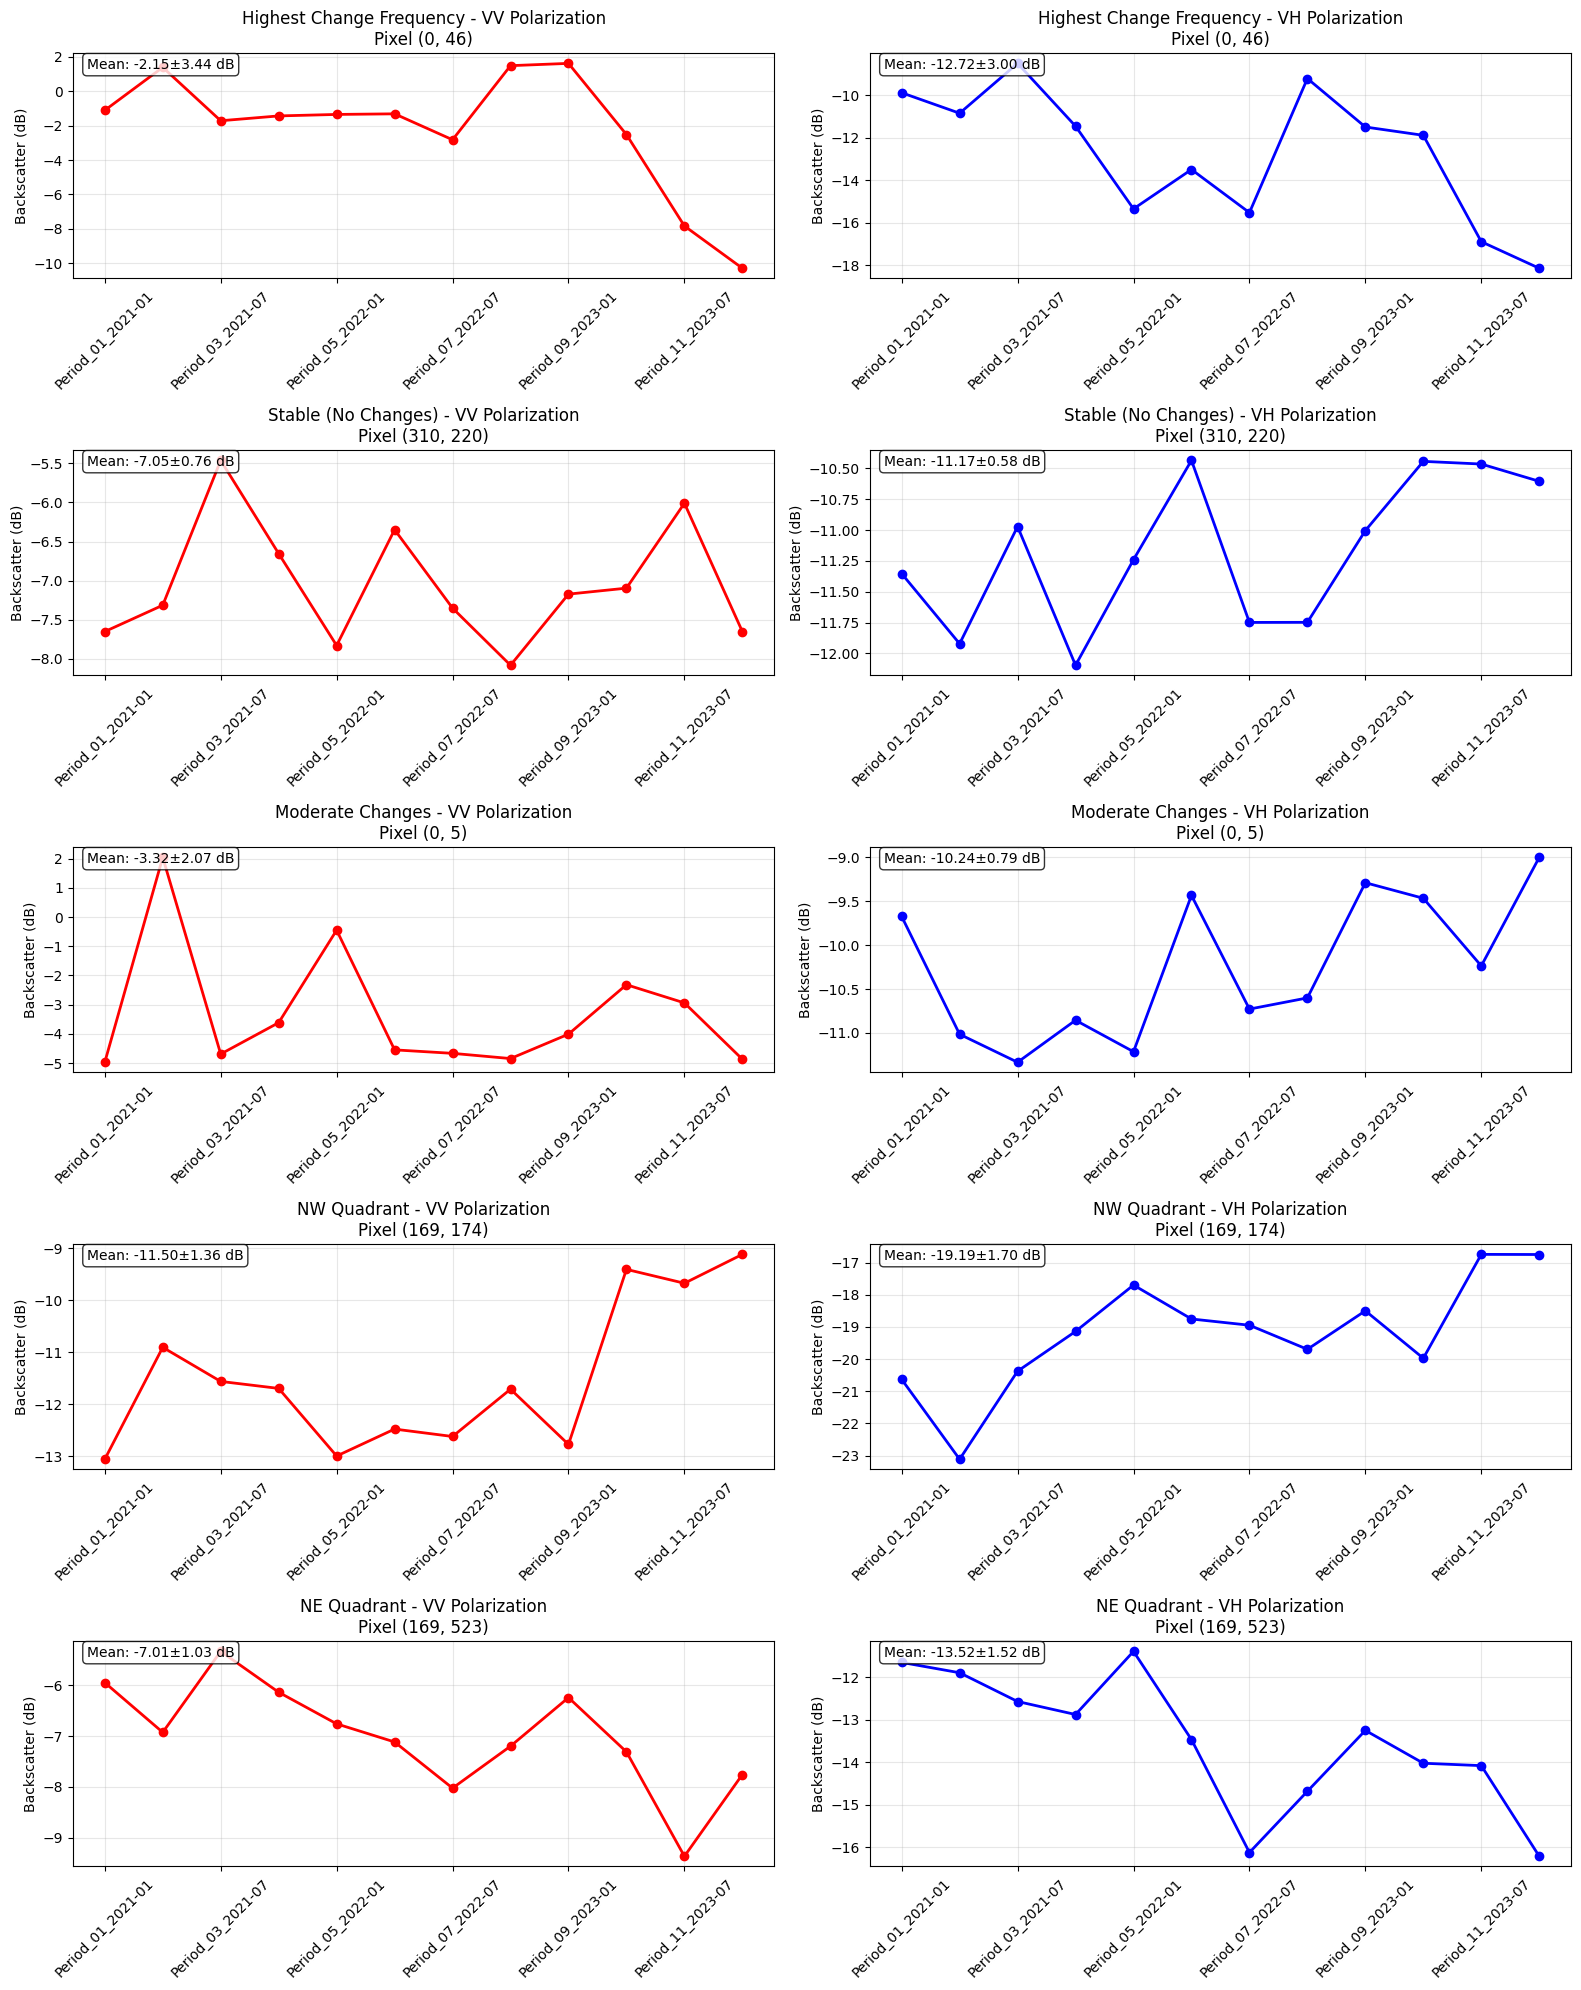


Time-series Analysis Interpretation:
- Sudden increases in backscatter may indicate new construction
- Gradual changes may indicate ongoing development
- Stable values indicate no significant land cover changes
- VV is more sensitive to building structures
- VH is more sensitive to vegetation and surface roughness changes


In [22]:
# Create time-series plots for selected pixels
if len(datasets) > 1:
    # Create time axis
    time_axis = range(len(time_labels))

    # Create subplots for time-series
    fig, axes = plt.subplots(len(analysis_pixels), 2, figsize=(16, 4*len(analysis_pixels)))

    if len(analysis_pixels) == 1:
        axes = axes.reshape(1, -1)

    for i, (row, col, desc) in enumerate(analysis_pixels):
        # Extract time series for this pixel
        vv_ts = vv_timeseries[:, row, col]
        vh_ts = vh_timeseries[:, row, col]

        # Plot VV time series
        axes[i, 0].plot(time_axis, vv_ts, 'o-', color='red', linewidth=2, markersize=6)
        axes[i, 0].set_title(f'{desc} - VV Polarization\nPixel ({row}, {col})')
        axes[i, 0].set_ylabel('Backscatter (dB)')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_xticks(time_axis[::2])  # Show every other label
        axes[i, 0].set_xticklabels([time_labels[j] for j in time_axis[::2]], rotation=45)

        # Plot VH time series
        axes[i, 1].plot(time_axis, vh_ts, 'o-', color='blue', linewidth=2, markersize=6)
        axes[i, 1].set_title(f'{desc} - VH Polarization\nPixel ({row}, {col})')
        axes[i, 1].set_ylabel('Backscatter (dB)')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].set_xticks(time_axis[::2])
        axes[i, 1].set_xticklabels([time_labels[j] for j in time_axis[::2]], rotation=45)

        # Add statistics
        vv_mean, vv_std = np.mean(vv_ts), np.std(vv_ts)
        vh_mean, vh_std = np.mean(vh_ts), np.std(vh_ts)

        axes[i, 0].text(0.02, 0.98, f'Mean: {vv_mean:.2f}±{vv_std:.2f} dB',
                       transform=axes[i, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        axes[i, 1].text(0.02, 0.98, f'Mean: {vh_mean:.2f}±{vh_std:.2f} dB',
                       transform=axes[i, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print('\nTime-series Analysis Interpretation:')
    print('- Sudden increases in backscatter may indicate new construction')
    print('- Gradual changes may indicate ongoing development')
    print('- Stable values indicate no significant land cover changes')
    print('- VV is more sensitive to building structures')
    print('- VH is more sensitive to vegetation and surface roughness changes')
else:
    print('Cannot create time-series plots - insufficient data')

## 9. Summary and Conclusions

This multitemporal analysis provides comprehensive insights into urban development patterns in New Delhi.

In [23]:
# Generate summary statistics
if len(datasets) > 1:
    print('=== MULTITEMPORAL CHANGE DETECTION SUMMARY ===')
    print(f'Analysis period: {time_labels[0]} to {time_labels[-1]}')
    print(f'Number of time periods analyzed: {len(datasets)}')
    print(f'Spatial extent: {spatial_extent}')
    print(f'Image dimensions: {vv_timeseries.shape[1]} x {vv_timeseries.shape[2]} pixels')

    # Change frequency statistics
    total_pixels = combined_change_frequency.size
    changed_pixels = np.sum(combined_change_frequency > 0)
    high_change_pixels = np.sum(combined_change_frequency_pct > 50)

    print('\n=== CHANGE FREQUENCY ANALYSIS ===')
    print(f'Total pixels: {total_pixels:,}')
    print(f'Pixels with changes: {changed_pixels:,} ({changed_pixels/total_pixels*100:.1f}%)')
    print(f'Pixels with high change frequency (>50%): {high_change_pixels:,} ({high_change_pixels/total_pixels*100:.1f}%)')
    print(f'Average change frequency: {np.mean(combined_change_frequency_pct):.1f}%')

    print('\n=== KEY FINDINGS ===')
    print('1. Urban development is most active in areas with high change frequency')
    print('2. Time-series analysis reveals both gradual and sudden changes')
    print('3. VV polarization is more sensitive to building construction')
    print('4. VH polarization captures vegetation and surface texture changes')
    print('5. Multitemporal approach provides more robust change detection than bi-temporal')

    print('\n=== APPLICATIONS ===')
    print('- Urban planning and monitoring')
    print('- Infrastructure development tracking')
    print('- Environmental impact assessment')
    print('- Policy making for sustainable development')
else:
    print('Insufficient data for comprehensive summary')

=== MULTITEMPORAL CHANGE DETECTION SUMMARY ===
Analysis period: Period_01_2021-01 to Period_12_2023-10
Number of time periods analyzed: 12
Spatial extent: {'west': 77.05, 'east': 77.12, 'south': 28.42, 'north': 28.48, 'crs': 'EPSG:4326'}
Image dimensions: 678 x 698 pixels

=== CHANGE FREQUENCY ANALYSIS ===
Total pixels: 473,244
Pixels with changes: 463,714 (98.0%)
Pixels with high change frequency (>50%): 123,879 (26.2%)
Average change frequency: 38.5%

=== KEY FINDINGS ===
1. Urban development is most active in areas with high change frequency
2. Time-series analysis reveals both gradual and sudden changes
3. VV polarization is more sensitive to building construction
4. VH polarization captures vegetation and surface texture changes
5. Multitemporal approach provides more robust change detection than bi-temporal

=== APPLICATIONS ===
- Urban planning and monitoring
- Infrastructure development tracking
- Environmental impact assessment
- Policy making for sustainable development


In [ ]:
# Clean up downloaded files (optional)
import os

print('\n=== CLEANUP ===')
print('Downloaded files:')
for period_name, filename in downloaded_files:
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / (1024*1024)  # MB
        print(f'  {filename} ({file_size:.1f} MB)')

# Uncomment the following lines to remove downloaded files
# for period_name, filename in downloaded_files:
#     if os.path.exists(filename):
#         os.remove(filename)
# print('Downloaded files cleaned up')

print('\nMultitemporal analysis completed successfully!')